# Chapter7 课堂示例——Python神经网络基础

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torch import nn # nn是神经网络的缩写
from torch.utils import data
from torchsummary import summary

## 数据预处理

### 生成数据

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.9226, 0.5581]) 
label: tensor([4.1470])


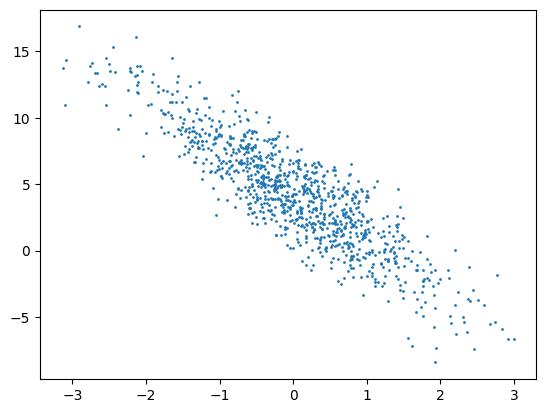

In [6]:
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
plt.show()

### 读取数据

In [7]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [8]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [9]:
next(iter(data_iter))

[tensor([[ 0.7910, -0.5648],
         [ 0.2651, -2.1253],
         [-0.3876, -1.2789],
         [-0.7502, -0.3449],
         [-1.1083,  0.9055],
         [ 0.6049, -0.1269],
         [-0.0346,  1.3689],
         [-1.0595, -0.2978],
         [ 1.1842, -2.0563],
         [-0.6445, -0.9684]]),
 tensor([[ 7.6979],
         [11.9639],
         [ 7.7652],
         [ 3.8768],
         [-1.0871],
         [ 5.8370],
         [-0.5468],
         [ 3.0825],
         [13.5537],
         [ 6.2163]])]

## 单层神经网络

### 定义模型

In [10]:
net = nn.Sequential(nn.Linear(2, 1))

### 初始化模型参数

In [11]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [12]:
loss = nn.MSELoss()

### 定义优化算法

In [13]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练模型

In [14]:
num_epochs = 3
# 训练三轮
for epoch in range(num_epochs):
    # 每次分批训练
    for X, y in data_iter:
        # 前向反馈
        y_hat = net(X)
        # 计算损失
        l = loss(y_hat, y)
        # 计算梯度
        trainer.zero_grad() # 清理梯度
        l.backward() # 计算梯度
        # 更新参数
        trainer.step()
    l = loss(net(features), labels) # 训练一轮之后的参数
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000182
epoch 2, loss 0.000099
epoch 3, loss 0.000099


In [15]:
w = net[0].weight.data
b = net[0].bias.data
print(w)
print(b)

tensor([[ 2.0005, -3.3994]])
tensor([4.2004])


In [16]:
print('w的估计误差：', true_w - w.reshape(true_w.shape))
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0005, -0.0006])
b的估计误差： tensor([-0.0004])


## 多层感知机（MLP）

### 定义模型

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features = input_size, out_features = hidden_size),    # 线性层
            nn.ReLU(),                                                          # 激活函数
            nn.Linear(in_features = hidden_size, out_features = output_size),   # 线性层
        )

    def forward(self, input):
        output = self.mlp(input)
        return output

In [18]:
input_dim = 2   # 输入层的维度
hidden_dim = 5  # 隐藏层的维度
output_dim = 1  # 输出层的维度
mlp = MLP(input_dim, hidden_dim, output_dim)

In [19]:
print(mlp)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [20]:
summary(mlp, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 5]              15
              ReLU-2                 [-1, 1, 5]               0
            Linear-3                 [-1, 1, 1]               6
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### 定义损失函数

In [21]:
mlp_loss = nn.MSELoss()   # 交叉熵

### 定义优化器

In [22]:
mlp_optimizer = torch.optim.SGD(mlp.parameters(), lr = 0.01)   # 随机梯度下降算法

### 训练模型

In [23]:
num_epochs = 3
# 训练三轮
for epoch in range(num_epochs):
    # 每次分批训练
    for X, y in data_iter:
        # 前向反馈
        y_hat = mlp(X)
        # 计算损失
        mlp_loss = loss(y_hat, y)
        # 计算梯度
        mlp_optimizer.zero_grad() # 清理梯度
        mlp_loss.backward() # 计算梯度
        # 更新参数
        mlp_optimizer.step()
    l = loss(mlp(features), labels) # 训练一轮之后的参数
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 1.614654
epoch 2, loss 1.179055
epoch 3, loss 0.916227


# 课堂练习